# Correlation Analysis

This code trains the linear regression model, using the layer activation for CAM visualization as input feature, and retinal morphometry as predictor. The regression is performed by 10-fold cross validation, and the prediction result is plotted. 

No valid cache found — computing results...


Evaluating Regression_ZoneC: 100%|██████████| 24/24 [04:11<00:00, 10.47s/it]


Saved results to ./fig_out/performance_with_95CI_sorted_by_r.csv
Figure saved to:
- ./fig_out/Correlation_Analysis.png
- ./fig_out/Correlation_Analysis.pdf
- ./fig_out/Correlation_Analysis.tiff


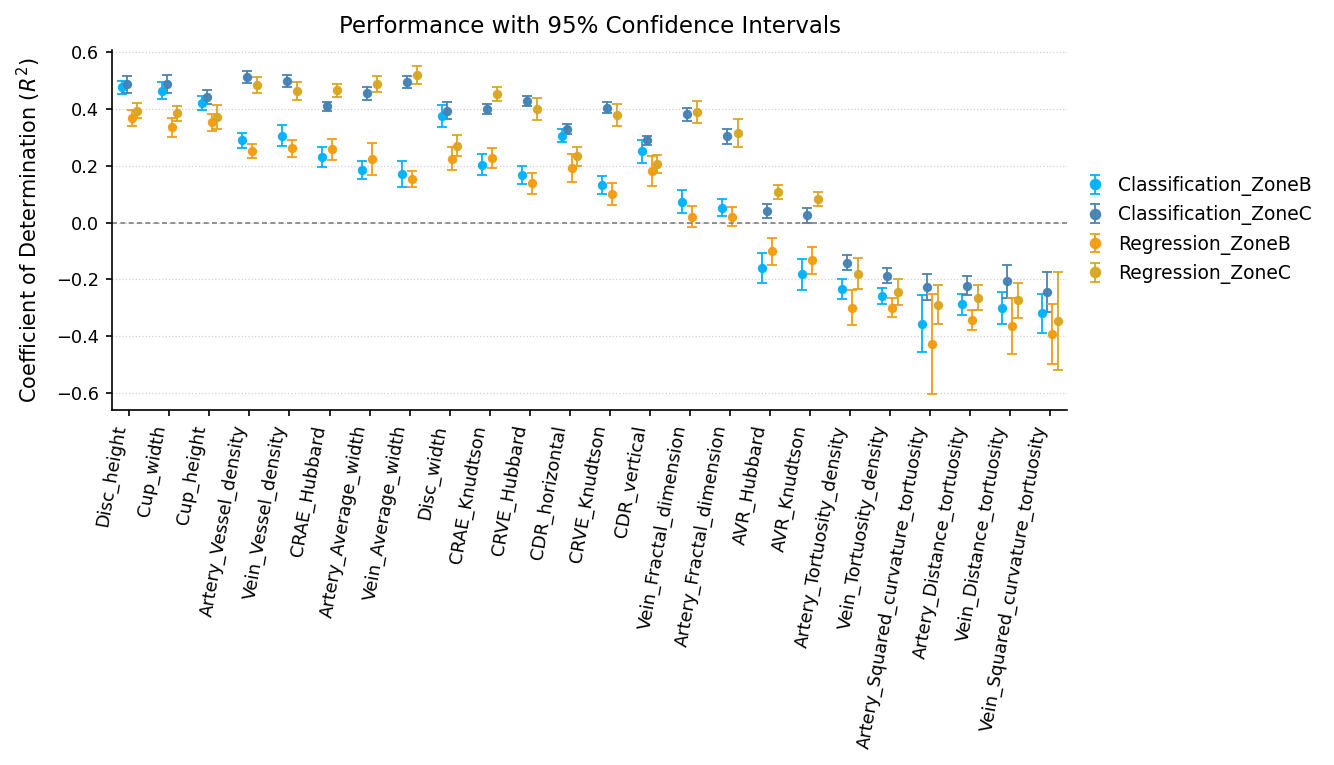

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

# ---------------- Config ----------------
score = "r2"
folds = 10
rng_seed = 42
USE_CACHED_RESULTS = True
outdir = "./fig_out"
os.makedirs(outdir, exist_ok=True)
RESULT_CSV = os.path.join(outdir, "performance_with_95CI_sorted_by_r.csv")

# figure defaults
mpl.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 8.5,
    "ytick.labelsize": 8.5,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "figure.dpi": 150,
})

COLORS = {
    "Classification_ZoneB": "#00B2FF",
    "Classification_ZoneC": "#4682B4",
    "Regression_ZoneB": "#F39C12",
    "Regression_ZoneC": "#DAA520",
}

required_cols = [
    "Measures",
    "Classification_ZoneB_Mean", "Classification_ZoneB_lo", "Classification_ZoneB_hi", "Classification_ZoneB_r",
    "Classification_ZoneC_Mean", "Classification_ZoneC_lo", "Classification_ZoneC_hi", "Classification_ZoneC_r",
    "Regression_ZoneB_Mean", "Regression_ZoneB_lo", "Regression_ZoneB_hi", "Regression_ZoneB_r",
    "Regression_ZoneC_Mean", "Regression_ZoneC_lo", "Regression_ZoneC_hi", "Regression_ZoneC_r",
    "mean_r",
]

def have_valid_cache(path: str) -> bool:
    if not (USE_CACHED_RESULTS and os.path.exists(path)):
        return False
    try:
        _ = pd.read_csv(path)
        return True
    except Exception:
        return False

def eval_group(df: pd.DataFrame, measures, group_name: str, folds: int = 10, score: str = "r2", seed: int = 42) -> pd.DataFrame:
    X = df.iloc[:, 1:1537].to_numpy()
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    rows = []
    for m in tqdm(measures, desc=f"Evaluating {group_name}"):
        y = df[m].to_numpy()
        model = LinearRegression()

        scores = cross_val_score(model, X, y, cv=kf, scoring=score)
        if isinstance(score, str) and score.startswith("neg_"):
            scores = -scores

        mean = scores.mean()
        se = stats.sem(scores)
        h = stats.t.ppf(0.975, df=len(scores) - 1) * se
        lo, hi = mean - h, mean + h

        y_hat = cross_val_predict(model, X, y, cv=kf)
        r, _ = pearsonr(y, y_hat)

        rows.append([m, mean, lo, hi, se, r])

    res = pd.DataFrame(
        rows,
        columns=[
            "Measure",
            f"{group_name}_Mean",
            f"{group_name}_lo",
            f"{group_name}_hi",
            f"{group_name}_SE",
            f"{group_name}_r",
        ],
    )
    return res.set_index("Measure")

# ---------------- Load cached results or recompute ----------------
if have_valid_cache(RESULT_CSV):
    print(f"Using cached results: {RESULT_CSV}")
    result_df = pd.read_csv(RESULT_CSV)
else:
    print("No valid cache found — computing results...")

    # ----- Load raw data -----
    classification_activation_df = pd.read_csv("./Classification_Activation.csv")
    classification_macular_b = pd.read_csv("../AutoMorph/Classification/M3/Macular_centred/Macular_Zone_B_Measurement_scaled.csv", index_col=0)
    classification_macular_c = pd.read_csv("../AutoMorph/Classification/M3/Macular_centred/Macular_Zone_C_Measurement_scaled.csv", index_col=0)

    classification_activation_df.rename(columns={classification_activation_df.columns[0]: "Name"}, inplace=True)
    classification_all_b_df = pd.merge(classification_activation_df, classification_macular_b, on="Name", how="left").dropna()
    classification_all_c_df = pd.merge(classification_activation_df, classification_macular_c, on="Name", how="left").dropna()

    regression_activation_df = pd.read_csv("./Regression_Activation.csv")
    regression_macular_b = pd.read_csv("../AutoMorph/Regression/M3/Macular_centred/Macular_Zone_B_Measurement_scaled.csv", index_col=0)
    regression_macular_c = pd.read_csv("../AutoMorph/Regression/M3/Macular_centred/Macular_Zone_C_Measurement_scaled.csv", index_col=0)

    regression_activation_df.rename(columns={regression_activation_df.columns[0]: "Name"}, inplace=True)
    regression_all_b_df = pd.merge(regression_activation_df, regression_macular_b, on="Name", how="left").dropna()
    regression_all_c_df = pd.merge(regression_activation_df, regression_macular_c, on="Name", how="left").dropna()

    # Measures (replicating your previous filtering)
    measure_list = classification_macular_b.columns[1:31].tolist()
    for _ in range(6):
        measure_list.pop(6)

    # Compute metrics
    g1 = eval_group(classification_all_b_df, measure_list, "Classification_ZoneB", folds, score, rng_seed)
    g2 = eval_group(classification_all_c_df, measure_list, "Classification_ZoneC", folds, score, rng_seed)
    g3 = eval_group(regression_all_b_df, measure_list, "Regression_ZoneB", folds, score, rng_seed)
    g4 = eval_group(regression_all_c_df, measure_list, "Regression_ZoneC", folds, score, rng_seed)

    result_df = (
        pd.concat([g1, g2, g3, g4], axis=1)
        .reset_index()
        .rename(columns={"index": "Measures"})
    )

    r_cols = [c for c in result_df.columns if c.endswith("_r")]
    result_df["mean_r"] = result_df[r_cols].mean(axis=1)
    result_df = result_df.sort_values("mean_r", ascending=False).reset_index(drop=True)

    # Export tidy cache for future runs
    result_df.to_csv(RESULT_CSV, index=False)
    print(f"Saved results to {RESULT_CSV}")

# ---------------- Plot from result_df (cached or computed) ----------------
fig_w, fig_h = 9, 5.2
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

x = np.arange(len(result_df))
jitter = 0.13
groups = [
    ("Classification_ZoneB", -1.5 * jitter),
    ("Classification_ZoneC", -0.5 * jitter),
    ("Regression_ZoneB", 0.5 * jitter),
    ("Regression_ZoneC", 1.5 * jitter),
]

for name, dx in groups:
    y = result_df[f"{name}_Mean"].to_numpy()
    lo = result_df[f"{name}_lo"].to_numpy()
    hi = result_df[f"{name}_hi"].to_numpy()
    yerr = np.vstack([y - lo, hi - y])
    color = COLORS[name]

    ax.errorbar(
        x + dx,
        y,
        yerr=yerr,
        fmt="o",
        markersize=3.5,
        linewidth=0.9,
        ecolor=color,
        elinewidth=0.9,
        capsize=2.5,
        capthick=0.9,
        markerfacecolor=color,
        markeredgecolor=color,
        label=name,
        alpha=0.95,
    )

ax.axhline(0, color="0.5", linestyle="--", linewidth=0.8, dashes=(3, 2))
ax.set_ylabel("Coefficient of Determination ($R^2$)", labelpad=6)
ax.set_title("Performance with 95% Confidence Intervals", pad=8)

ax.set_xticks(x)
ax.set_xticklabels(result_df["Measure"], rotation=80, ha="right")
ax.margins(x=0.01)
ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.6)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    frameon=False,
    ncol=1,
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    markerscale=1.3,   # scales the marker size in the legend
    handlelength=1.2,  # a bit longer swatch for readability
    handletextpad=0.6,
    borderaxespad=0.0,
)

fig.tight_layout()

png_path = os.path.join(outdir, "Correlation_Analysis.png")
pdf_path = os.path.join(outdir, "Correlation_Analysis.pdf")
tif_path = os.path.join(outdir, "Correlation_Analysis.tiff")

fig.savefig(png_path, dpi=600, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")
fig.savefig(tif_path, dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches="tight")

print(f"Figure saved to:\n- {png_path}\n- {pdf_path}\n- {tif_path}")


In [2]:
# The length of measurement and activation dataframe does not match because some images were not able to extract the morphometry info.

classification_activation_df = pd.read_csv('./Classification_Activation.csv')
classification_macular_b = pd.read_csv('../AutoMorph/Classification/M3/Macular_centred/Macular_Zone_B_Measurement_scaled.csv', index_col=0)
classification_macular_c = pd.read_csv('../AutoMorph/Classification/M3/Macular_centred/Macular_Zone_C_Measurement_scaled.csv', index_col=0)
classification_activation_df.columns.values[0] = 'Name'

classification_all_b_df = pd.merge(classification_activation_df, classification_macular_b, on='Name', how="left").dropna()
classification_all_c_df = pd.merge(classification_activation_df, classification_macular_c, on='Name', how="left").dropna()

In [3]:
# The length of measurement and activation dataframe does not match because some images were not able to extract the morphometry info.

regression_activation_df = pd.read_csv('./Regression_Activation.csv')
regression_macular_b = pd.read_csv('../AutoMorph/Regression/M3/Macular_centred/Macular_Zone_B_Measurement_scaled.csv', index_col=0)
regression_macular_c = pd.read_csv('../AutoMorph/Regression/M3/Macular_centred/Macular_Zone_C_Measurement_scaled.csv', index_col=0)
regression_activation_df.columns.values[0] = 'Name'

regression_all_b_df = pd.merge(regression_activation_df, regression_macular_b, on='Name', how="left").dropna()
regression_all_c_df = pd.merge(regression_activation_df, regression_macular_c, on='Name', how="left").dropna()

In [11]:
from scipy import stats
measure_list = classification_macular_b.columns[1:31].tolist()
measure_list.pop(6)
measure_list.pop(6)
measure_list.pop(6)
measure_list.pop(6)
measure_list.pop(6)
measure_list.pop(6)


classi_b_mean_list = []
classi_b_ste_list = []

for measure in measure_list:
    variable = measure
    
    X = classification_all_b_df.iloc[:, 1:1537].to_numpy()
    y = classification_all_b_df[variable].to_numpy()
    
    model=LinearRegression()
    scores = cross_val_score(model, X, y, cv=fold, scoring=score)
    
    classi_b_mean_list.append(scores.mean())
    classi_b_ste_list.append(stats.sem(scores))

In [12]:
classi_c_mean_list = []
classi_c_ste_list = []

for measure in measure_list:
    variable = measure
    
    X = classification_all_c_df.iloc[:, 1:1537].to_numpy()
    y = classification_all_c_df[variable].to_numpy()
    
    model=LinearRegression()
    scores = cross_val_score(model, X, y, cv=fold, scoring=score)
    
    classi_c_mean_list.append(scores.mean())
    classi_c_ste_list.append(stats.sem(scores))

In [13]:
reg_c_mean_list = []
reg_c_ste_list = []

for measure in measure_list:
    variable = measure
    
    X = regression_all_c_df.iloc[:, 1:1537].to_numpy()
    y = regression_all_c_df[variable].to_numpy()
    
    model=LinearRegression()
    scores = cross_val_score(model, X, y, cv=fold, scoring=score)
    
    reg_c_mean_list.append(scores.mean())
    reg_c_ste_list.append(stats.sem(scores))

In [14]:
reg_b_mean_list = []
reg_b_ste_list = []

for measure in measure_list:
    variable = measure
    
    X = regression_all_b_df.iloc[:, 1:1537].to_numpy()
    y = regression_all_b_df[variable].to_numpy()
    
    model=LinearRegression()
    scores = cross_val_score(model, X, y, cv=fold, scoring=score)
    
    reg_b_mean_list.append(scores.mean())
    reg_b_ste_list.append(stats.sem(scores))

In [16]:
result_df = pd.DataFrame(columns=['Measures', 'Classi_B_Mean', 'Classi_B_Ste', 'Classi_C_Mean', 'Classi_C_Ste',
                                 'Regress_B_Mean', 'Regress_B_Ste', 'Regress_C_Mean', 'Regress_C_Ste',])

result_df['Measures'] = measure_list

result_df['Classi_B_Mean'] = classi_b_mean_list
result_df['Classi_B_Ste'] = classi_b_ste_list
result_df['Classi_C_Mean'] = classi_c_mean_list
result_df['Classi_C_Ste'] = classi_c_ste_list

result_df['Regress_B_Mean'] = reg_b_mean_list
result_df['Regress_B_Ste'] = reg_b_ste_list
result_df['Regress_C_Mean'] = reg_c_mean_list
result_df['Regress_C_Ste'] = reg_c_ste_list

In [17]:
result_df

,Measures,Classi_B_Mean,Classi_B_Ste,Classi_C_Mean,Classi_C_Ste,Regress_B_Mean,Regress_B_Ste,Regress_C_Mean,Regress_C_Ste
0,Disc_height,0.475399,0.005289,0.485892,0.006519,0.381600,0.013570,0.395544,0.016011
1,Disc_width,0.372599,0.014574,0.393980,0.014591,0.222232,0.012099,0.275514,0.014814
2,Cup_height,0.422102,0.016004,0.438611,0.016764,0.357112,0.013250,0.372328,0.019723
3,Cup_width,0.463973,0.011459,0.486139,0.008276,0.349059,0.006630,0.386928,0.011387
4,CDR_vertical,0.262347,0.011101,0.292639,0.013326,0.169629,0.013205,0.207771,0.013453
5,CDR_horizontal,0.302283,0.016424,0.327296,0.013692,0.199174,0.016925,0.238629,0.018300
6,Artery_Fractal_dimension,0.045254,0.011734,0.310402,0.011502,0.006858,0.018702,0.314826,0.018906
7,Artery_Vessel_density,0.288713,0.013342,0.516036,0.008778,0.251952,0.017950,0.483454,0.016659
8,Artery_Average_width,0.186960,0.009502,0.452795,0.011399,0.212245,0.015599,0.493388,0.008409
9,Artery_Distance_tortuosity,-0.301474,0.022806,-0.224827,0.023752,-0.353201,0.026404,-0.253421,0.019516
